# data_algebra

[data_algebra](https://github.com/WinVector/data_algebra) is a piped data wrangling system
based on Codd's relational algebra and experience working with data manipulation languages at scale.
The primary purpose of the package is to support an easy to
compose and maintain grammar of data processing steps that in turn can be used to generate
database specific SQL. The package also implements the same transforms for Pandas DataFrames.

Currently the system is primarily adapted and testing for Pandas, Google BigQuery, PostgreSQL, and
SQLite. Extension to other data processing systems such as Spark and MariaDB is possible, but
not currently supported/tested.

[This](https://github.com/WinVector/data_algebra) is to be the [`Python`](https://www.python.org) equivalent of the [`R`](https://www.r-project.org) packages [`rquery`](https://github.com/WinVector/rquery/), [`rqdatatable`](https://github.com/WinVector/rqdatatable), and [`cdata`](https://CRAN.R-project.org/package=cdata).  This package will supply piped Codd-transform style notation that can perform data engineering in [`Pandas`](https://pandas.pydata.org) and generate [`SQL`](https://en.wikipedia.org/wiki/SQL) queries from the same specification.

# Installing

Install `data_algebra` with `pip install data_algebra`

# Announcement

This article introduces the [`data_algebra`](https://github.com/WinVector/data_algebra) project: a data processing tool family available in `R` and `Python`.  These tools are designed to transform data either in-memory or on remote databases.  For an example (with video) of using `data_algebra` to re-arrange data layout please see [here](https://github.com/WinVector/data_algebra/blob/master/Examples/cdata/ranking_pivot_example.md).

In particular, we will discuss the `Python` implementation (also called `data_algebra`) and its relation to the mature `R` implementations (`rquery` and `rqdatatable`).

## Introduction

The project intent is to realize a method chained data processing language based on [Codd's relational operators](https://en.wikipedia.org/wiki/Relational_model) that is easy to maintain, has helpful tooling, and has very similar realizations (or dialects) for:

  * [`SQL`](https://en.wikipedia.org/wiki/SQL) databases accessed from [`Python`](https://www.python.org), useful working at scale with `PostgreSQL` or Apache `Spark` (`Spark` example [here](https://github.com/WinVector/data_algebra/blob/master/Examples/Spark/pyspark_example.ipynb)).
  * [`Pandas`](https://pandas.pydata.org) `DataFrame` objects in `Python`.
  * `SQL` databases access from [`R`](https://www.r-project.org) (implementation is [here](https://github.com/WinVector/rquery), and is mature and ready for production use).
  
The intent is the notation should look idiomatic in each language.  Working in `Python` should feel like working in `Python`, and working in `R` should feel like working in `R`.  The data semantics, however, are designed to be close to the `SQL` realizations (given the close connection of `SQL` to the relational algebra; in particular row numbering starts at `1` and row and column order is not preserved except at row-order steps or select-columns steps respectively). The intent is: it should be very easy to use the system in either `Python` or `R` (a boon to multi-language data science projects) and it is easy to port either code or experience from one system to another (a boon for porting projects, or for data scientists working with more than one code base or computer language).

Related work includes:

  * [Codd's relational algebra](https://en.wikipedia.org/wiki/Relational_algebra)
  * [`SQL`](https://en.wikipedia.org/wiki/SQL)
  * [`data.table`](https://CRAN.R-project.org/package=data.table)
  * [`dfply`](https://github.com/kieferk/dfply)
  * [`dplython`](https://github.com/dodger487/dplython)
  * [`LINQ`](https://en.wikipedia.org/wiki/Language_Integrated_Query)
  * [`Apache Calcite`](https://calcite.apache.org)
  * [`dplyr`](https://CRAN.R-project.org/package=dplyr)
  * [`dtplyr`](https://CRAN.R-project.org/package=dtplyr)
  * [`table.express`](https://github.com/asardaes/table.express)
  * [`Pandas`](https://pandas.pydata.org)
  * [`pandas-ply`](https://github.com/coursera/pandas-ply)
  * [`SQLAlchemy`](https://www.sqlalchemy.org)
  * [`rquery`](https://github.com/WinVector/rquery/)
  * [`cdata`](https://github.com/WinVector/cdata/)
  * [`siuba`](https://github.com/machow/siuba)
  
The `data_algebra` principles include:

  * Writing data transforms as a pipeline or method-chain of many simple transform steps.
  * Treating data transform pipelines or directed acyclic graphs (DAGs) as themselves being sharable data.
  * Being able to use the same transform specification many places (in memory, on databases, in `R`, in `Python`).

The `data_algebra` supplies two primary services:

  * Building composite data processing pipelines (which we demonstrate in this note).
  * Building record transforms (which we demonstrate [here](https://github.com/WinVector/data_algebra/blob/master/Examples/cdata/cdata_general_example.ipynb)).

## Example

Let's start with a pipeline example in `Python` (for a record transform example, please see [here](https://github.com/WinVector/data_algebra/blob/master/Examples/cdata/cdata_general_example.ipynb)).

For our example we will assume we have a data set of how many points different subjects score in a psychological survey.  The goal is transform the data so that we see what fraction of the subjects answers are in each category (subject to an exponential transform, as often used in [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)).  We then treat the per-subject renormalized data as a probability or diagnosis.

The exact meaning of such a scoring method are not the topic of this note.  It is a notional example to show a non-trivial data transformation need.  In particular: having to normalize per-subject (divide some set of scores per-subject by a per-subject total) is a classic pain point in data-processing.  In classic `SQL` this can only be done by joining against a summary table, or in more modern `SQL` with a "[window function](https://en.wikipedia.org/wiki/SQL_window_function)." We want to show by working in small enough steps this can be done simply.

### Set up

Let's start our `Python` example.  First we import the packages we are going to use, and set a few options.


In [1]:
import sqlite3
import sqlalchemy
import pandas
from data_algebra.data_ops import *  # https://github.com/WinVector/data_algebra
import data_algebra.PostgreSQL
import data_algebra.SQLite

data_algebra.__version__

'0.7.3'

Now let's type in our example data.  Notice this is an in-memory `Pandas` `Data.Frame`.


In [2]:
d_local = pandas.DataFrame({
    'subjectID':[1, 1, 2, 2],
    'surveyCategory': [ "withdrawal behavior", "positive re-framing", "withdrawal behavior", "positive re-framing"],
    'assessmentTotal': [5., 2., 3., 4.],
    'irrelevantCol1': ['irrel1']*4,
    'irrelevantCol2': ['irrel2']*4,
})

d_local

,subjectID,surveyCategory,assessmentTotal,irrelevantCol1,irrelevantCol2
0,1,withdrawal behavior,5.0,irrel1,irrel2
1,1,positive re-framing,2.0,irrel1,irrel2
2,2,withdrawal behavior,3.0,irrel1,irrel2
3,2,positive re-framing,4.0,irrel1,irrel2



Let's also copy this data to a database.  Normally big data is already in the system one wants to work with, so the copying over is just to simulate the data already being there.


In [3]:
use_postgresql = True

if use_postgresql:
    db_handle = data_algebra.PostgreSQL.example_handle()
else:
    db_handle = data_algebra.SQLite.example_handle()


In [4]:
remote_table_desciption = db_handle.insert_table(d_local, table_name='d', allow_overwrite=True)

remote_table_desciption.head


,subjectID,surveyCategory,assessmentTotal,irrelevantCol1,irrelevantCol2
0,1,withdrawal behavior,5.0,irrel1,irrel2
1,1,positive re-framing,2.0,irrel1,irrel2
2,2,withdrawal behavior,3.0,irrel1,irrel2
3,2,positive re-framing,4.0,irrel1,irrel2



Normally one does not read data back from a database, but instead materializes results in the database with `SQL` commands such as `CREATE TABLE tablename AS SELECT ...`.
Also note: case in columns is a bit of nightmare.  It is often best to lower-case them all.

### Back to the `data_algebra`

Now we continue our example by importing the `data_algebra` components we need.

Now we use the `data_algebra` to define our processing pipeline: `ops`.  We are writing this pipeline using a [method chaining](https://en.wikipedia.org/wiki/Method_chaining) notation where we have placed `Python` method-dot at the end of lines using the `.\` notation.  This notation will look *very* much like a [pipe](https://en.wikipedia.org/wiki/Pipeline_(Unix)) to `R`/[`magrittr`](https://CRAN.R-project.org/package=magrittr) users.


In [5]:
scale = 0.237

ops = data_algebra.data_ops.describe_table(d_local, 'd'). \
    extend({'probability': f'(assessmentTotal * {scale}).exp()'}). \
    extend({'total': 'probability.sum()'},
           partition_by='subjectID'). \
    extend({'probability': 'probability/total'}). \
    extend({'row_number': '(1).cumsum()'},
           partition_by=['subjectID'],
           order_by=['probability'], reverse=['probability']). \
    select_rows('row_number == 1'). \
    select_columns(['subjectID', 'surveyCategory', 'probability']). \
    rename_columns({'diagnosis': 'surveyCategory'})


We are deliberately writing a longer pipeline of simple steps, so we can use the same pipeline locally with Pandas, and (potentially) great scale with `PostgreSQL` or Apache `Spark`.  A more concise variation of this pipeline can be found in the R example [here](https://github.com/WinVector/rquery).

The intent is: the user can build up very sophisticated processing pipelines using a small number of primitive steps.  The pipelines tend to be long, but can still be very efficient- as they are well suited for use with `Pandas` and with `SQL` query optimizers.  Most of the heavy lifting is performed by the  very powerful "window functions" (triggered by use of `partition_by` and `order_by`) available on the `extend()` step.  Multiple statements can be combined into extend steps, but only when they have the same window-structure, and don't create and use the same value name in the same statement (except for replacement, which is shown in this example).  Many conditions are checked and enforced during pipeline construction, making debugging very easy.

For a more Pythonic way of writing the same pipeline we can show how the code would have been formatted by [`black`](https://github.com/psf/black).


In [6]:
py_source = ops.to_python(pretty=True)

print(py_source)

TableDescription(
    table_name="d",
    column_names=[
        "subjectID",
        "surveyCategory",
        "assessmentTotal",
        "irrelevantCol1",
        "irrelevantCol2",
    ],
).extend({"probability": "((assessmentTotal * 0.237)).exp()"}).extend(
    {"total": "probability.sum()"}, partition_by=["subjectID"]
).extend(
    {"probability": "probability / total"}
).extend(
    {"row_number": "(1).cumsum()"},
    partition_by=["subjectID"],
    order_by=["probability"],
    reverse=["probability"],
).select_rows(
    "row_number == 1"
).select_columns(
    ["subjectID", "surveyCategory", "probability"]
).rename_columns(
    {"diagnosis": "surveyCategory"}
)



In either case, the pipeline is read as a sequence of operations (top to bottom, and left to right).  What it is saying is:

  * We start with a table named "d" that is known to have columns "subjectID", "surveyCategory", "assessmentTotal", "irrelevantCol1", and "irrelevantCol2".
  * We produce a new table by transforming this table through a sequence of "extend" operations which add new columns.
  
    * The first `extend` computes `probability = exp(scale*assessmentTotal)`, this is similar to the inverse-link step of a logistic regression. We assume when writing this pipeline we were given this math as a requirement.
    * The next few `extend` steps total the `probability` per-subject (this is controlled by the `partition_by` argument) and then rank the normalized probabilities per-subject (grouping again specified by the `partition_by` argument, and order controlled by the `order_by` clause).
    
  * We then select the per-subject top-ranked rows by the `select_rows` step.
  
  * And finally we clean up the results for presentation with the `select_columns`, `rename_columns`, and `order_rows` steps.  The names of these methods are intended to evoke what they do.
  
The point is: each step is deliberately so trivial one can reason about it. However the many steps in sequence do quite a lot.

### `SQL`

Once we have the `ops` object we can do quite a lot with it. We have already exhibited the pretty-printing of the pipeline. Next we demonstrate translating the operator pipeline into `SQL`.


In [7]:
sql = db_handle.to_sql(ops, pretty=True, use_with=True, annotate=True)

print(sql)

-- data_algebra SQL https://github.com/WinVector/data_algebra
--  dialect: PostgreSQLModel
--       string quote: '
--   identifier quote: "
WITH "table_reference_0" AS
  (SELECT "subjectID",
          "surveyCategory",
          "assessmentTotal"
   FROM "d"),
     "extend_1" AS
  (SELECT -- extend({ 'probability': '((assessmentTotal * 0.237)).exp()'})
 "subjectID",
 "surveyCategory",
 EXP(("assessmentTotal" * 0.237)) AS "probability"
   FROM "table_reference_0"),
     "extend_2" AS
  (SELECT -- extend({ 'total': 'probability.sum()'}, partition_by=['subjectID'])
 "subjectID",
 "surveyCategory",
 "probability",
 SUM("probability") OVER (PARTITION BY "subjectID") AS "total"
   FROM "extend_1"),
     "extend_3" AS
  (SELECT -- extend({ 'probability': 'probability / total'})
 "subjectID",
 "surveyCategory",
 "probability" / "total" AS "probability"
   FROM "extend_2"),
     "extend_4" AS
  (SELECT -- extend({ 'row_number': '(1).cumsum()'}, partition_by=['subjectID'], order_by=['probabilit


Older `SQL` can be hard to read, as `SQL` expresses composition by inner-nesting (inside `SELECT` statements happen first).  The operator pipeline expresses composition by sequencing or method-chaining, which can be a lot more legible.  In this example we use the SQL-99 common table expression (`WITH`) notation to manage the composition in a more legible manner. A huge advantage of the `SQL` is: we can send it to the database for execution, as we do now.

Also notice the generated `SQL` has applied query narrowing: columns not used in the outer queries are removed from the inner queries. The "irrelevant" columns are not carried into the calculation as they would be with a `SELECT *`.  This early optimization comes in quite handy.


In [8]:
db_handle.read_query(sql)

,diagnosis,subjectID,probability
0,withdrawal behavior,1,0.670622
1,positive re-framing,2,0.558974




What comes back is: one row per subject, with the highest per-subject diagnosis and the estimated probability. Again, the math of this is outside the scope of this note (think of that as something coming from a specification)- the ability to write such a pipeline is our actual topic.

The hope is that the `data_algebra` pipeline is easier to read, write, and maintain than the `SQL` query. If we wanted to change the calculation we would just add a stage to the `data_algebra` pipeline and then regenerate the `SQL` query.

### `Pandas`

An advantage of the pipeline is it can also be directly used on `Pandas` `DataFrame`s. Let's see how that is achieved.


In [9]:
ops.eval({'d': d_local})

,subjectID,diagnosis,probability
0,1,withdrawal behavior,0.670622
1,2,positive re-framing,0.558974




There is also a shorthand notation for single table source pipelines:


In [10]:
ops.transform(d_local)

,subjectID,diagnosis,probability
0,1,withdrawal behavior,0.670622
1,2,positive re-framing,0.558974



`eval` takes a dictionary of `Pandas` `DataFrame`s (names matching names specified in the pipeline) and returns the result of applying the pipeline to the data using `Pandas` commands.  Currently our `Pandas` implementation only allows very simple window functions.  This is why we didn't write `probability = probability/sum(probability)`, but instead broken the calculation into multiple steps by introducing the `total` column (the `SQL` realization does in fact support more complex window functions).  This is a small issue with the grammar: but our feeling encourage simple steps is in fact a good thing (improves debuggability), and in `SQL` the query optimizers likely optimize the different query styles into very similar realizations anyway.


## Export/Import

Because our operator pipeline is a `Python` object with no references to external objects (such as the database connection), it can be saved through standard methods such as "[pickling](https://docs.python.org/3/library/pickle.html)."

We can also diagram the pipeline using graphviz.


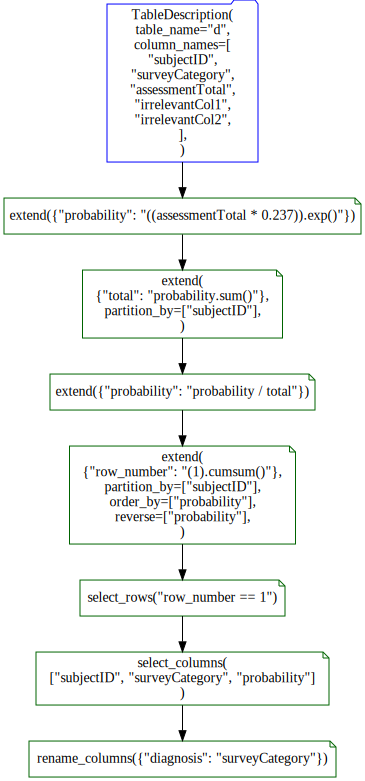

In [11]:
import graphviz

import data_algebra.diagram

dot = data_algebra.diagram.to_digraph(ops)
dot


## Advantages of `data_algebra`

A `data_algebra` operator pipeline carries around usable knowledge of the data transform.

For example:


In [12]:
# report all source table columns used by the query
ops.columns_used()

{'d': {'assessmentTotal', 'subjectID', 'surveyCategory'}}

In [13]:
# what columns does this operation produce?
ops.column_names

['subjectID', 'diagnosis', 'probability']

## Conclusion

The `data_algebra` is part of a powerful cross-language and mutli-implementaiton family data manipulation tools. These tools can greatly reduce the development and maintenance cost of data science projects, while improving the documentation of project intent.

[Win Vector LLC](http://www.win-vector.com/) is looking for sponsors and partners to further the package.  In particular if your group is using both `R` and `Python` in big-data projects (where `SQL` is a need, including [`Apache Spark`](https://spark.apache.org)), or are porting a project from one of these languages to another- please get in touch.



In [14]:
# be neat
db_handle.close()

Note: as with `SQL` the `data_algebra` assumes the processing pipeline is a [`DAG`](https://en.wikipedia.org/wiki/Directed_acyclic_graph) with only table-nodes used more than once.
